In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from data_frame import getDataFrame
from torchvision.utils import make_grid
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
from model_resnet9 import ResNet9
from PIL import Image

In [2]:
train_df = getDataFrame()
train_df = train_df[:5850]

In [6]:
BATCH = 8
EPOCHS = 10
LR = 0.005
IM_SIZE = 256

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.CenterCrop(500),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

In [4]:
img = cv2.imread('../../../../Volumes/T7/herbarium-2022-fgvc9/train_images/000/00/00000__002.jpg')

True

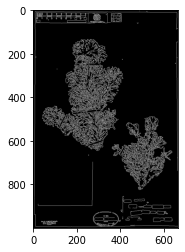

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)

canny = cv2.Canny(gray, 100, 200)



plt.imshow(canny, cmap ='gray')
cv2.imwrite('../output.jpg', canny)


In [7]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values

class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        # x = Image.open(self.fnames[index])
        x = cv2.imread(self.fnames[index])
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        mask = cv2.inRange(x, (165,155,115),(255,255,255))
        x[mask>0] = (0,0,0)
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset = GetData(X_Train, Y_Train, Transform)

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

def split_indices(n, val_pct=0.1, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

train_indices, val_indices = split_indices(len(trainset))

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(trainset, batch_size=BATCH, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(trainset, batch_size=BATCH, sampler=val_sampler)

images.shape: torch.Size([8, 3, 256, 256])


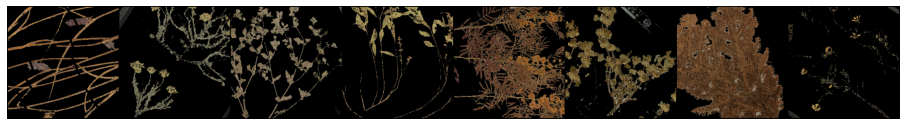

In [10]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = torchvision.models.densenet169(pretrained=True)
N_Classes = train_df['category'].nunique()

# for param in model.parameters():
#     param.requires_grad = False
    
# n_inputs = model.classifier.in_features
# last_layer = nn.Linear(n_inputs, N_Classes)
# model.classifier = last_layer

# if torch.cuda.is_available():
#     model.cuda()   

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters())


In [12]:
resnet9 = ResNet9(3, N_Classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet9.parameters(), lr=LR)
resnet9.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
 

In [13]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [14]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, resnet9, criterion, optimizer, scaler, device=device)
    torch.save(resnet9, './processimg.pth')
    eval_acc, eval_loss = evaluate(val_dl, resnet9, criterion, device=device)
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

/Users/terry/miniconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
  0%|          | 0/659 [00:00<?, ?it/s]/Users/terry/miniconda3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 74/74 [00:49<00:00,  1.48it/s]



Epoch 1 | Train Acc: 2.0675265789031982 | Train Loss: 5.195322513580322
	 Val Acc: 4.391891956329346 | Val Loss: 4.416514873504639


  3%|▎         | 17/659 [00:19<12:26,  1.16s/it]


KeyboardInterrupt: 